### Imports and config

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.dates import DateFormatter
from osgeo import gdal

matplotlib.rc('figure', dpi=150)
plt.rc('axes.formatter', useoffset=False)

transition_cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'orange'])

### Read and clean data

In [69]:
df = pd.read_csv(
    "data_github/sensitivity_data/full_sensitivity_analysis.csv",
    usecols=[1, 2, 3, 4, 5, 6],
)
# df = df[df.index <= 1104] # only need for this partial subset
# df.insert(0,'datetime',pd.to_datetime(df['riv_datetime'],format='%Y%m%d%H'))
df.index = pd.to_datetime(df["riv_datetime"], format="%Y%m%d%H")
df.index = df.index.rename("datetime")
df["surge_h"] = df["surge_h"] * 0.1
# df = df.copy()[df["surge_h"] >= 1.1]

df["n_coastal_norm"] = 100 * df["n_coastal"] / df["n_coastal"].max()
df["n_hydro_norm"] = 100 * df["n_hydro"] / df["n_hydro"].max()
df["n_trans_norm"] = 100 * df["n_trans"] / df["n_trans"].max()

# filter surge heights to make plot easier to read
df = df[
    (df.surge_h == 1.1)
    | (df.surge_h == 1.5)
    | (df.surge_h == 2)
    | (df.surge_h == 2.5)
    | (df.surge_h == 3)
    | (df.surge_h == 3.5)
]


### Plots

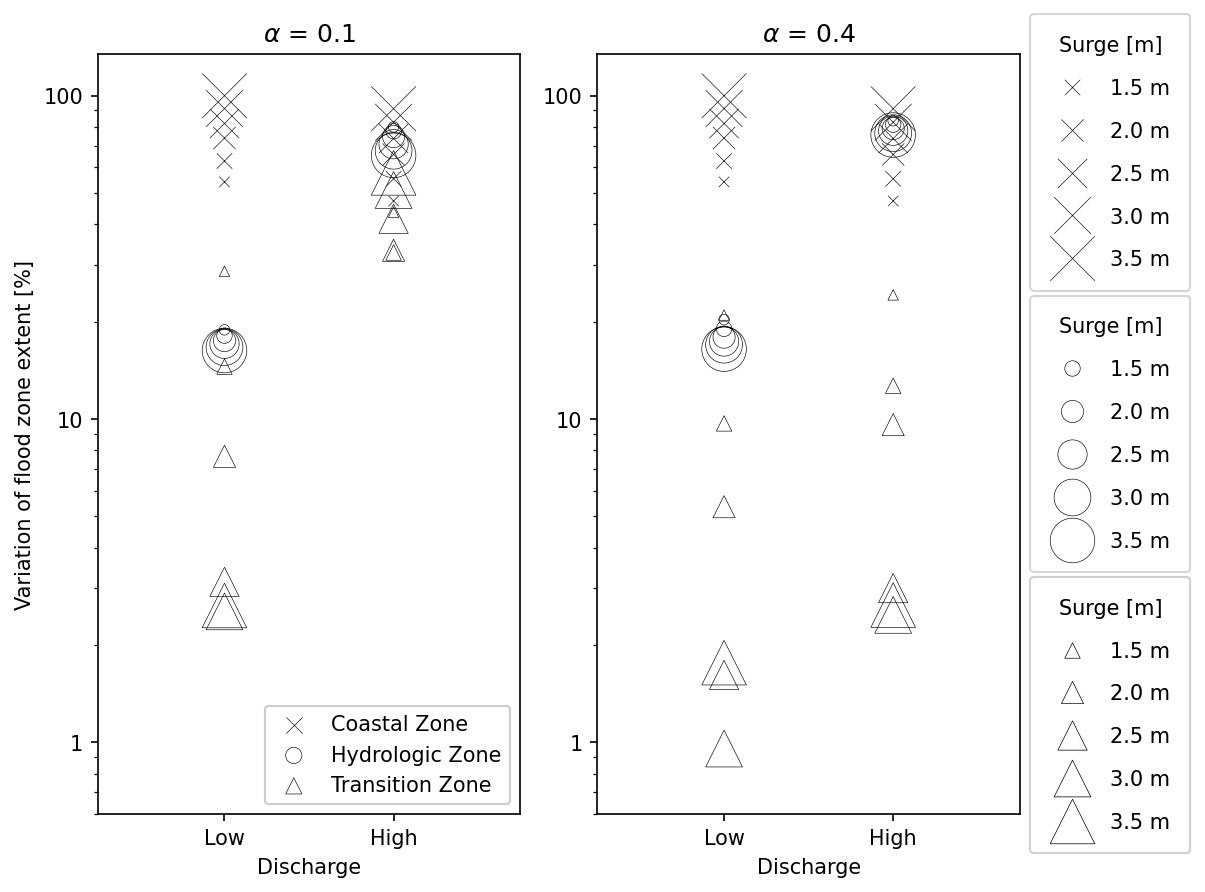

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(7, 6))

# y-axis is zone's area as a percentage of its max value among all scenarios
datetimes = ["2018-09-14 00:00", "2018-09-15 08:00"]

ax[0].set_ylabel("Variation of flood zone extent [%]")
for i, alpha in enumerate([0.1, 0.4]):
    # use less surge_h vals
    plot_df = df.copy()
    plot_df = plot_df.loc[datetimes]
    plot_df = plot_df[plot_df.alpha_val == alpha]

    x = np.repeat([0, 1], len(plot_df) / 2)

    # s_list1 = list(10 * 3.2**plot_df.surge_h)
    k, p = 20, 2.5
    s_list1 = list(k * plot_df.surge_h**p)

    sc_c = ax[i].scatter(
        x,
        plot_df.n_coastal_norm,
        s=s_list1,
        marker="x",
        c="k",
        linewidth=0.3,
        label="Coastal Zone",
    )

    sc_h = ax[i].scatter(
        x,
        plot_df.n_hydro_norm,
        s=s_list1,
        marker="o",
        facecolors="none",
        edgecolors="k",
        linewidth=0.3,
        label="Hydrologic Zone",
    )

    sc_t = ax[i].scatter(
        x,
        plot_df.n_trans_norm,
        s=s_list1,
        marker="^",
        facecolors="none",
        edgecolors="k",
        linewidth=0.3,
        label="Transition Zone",
    )

    ax[i].set(
        xlim=(-0.75, 1.75),
        ylim=(0.6, 135),
        xlabel="Discharge",
        title=rf"$\alpha$ = {alpha}",
    )

    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(["Low", "High"])

    ax[i].set_yscale("log")
    ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[i].yaxis.get_major_formatter().set_scientific(False)
    ax[i].yaxis.get_major_formatter().set_useOffset(False)

    kw = dict(
        prop="sizes",
        num=5,
        fmt="{x:.1f} m",
        func=lambda s: np.power(s / k, 1 / p),
    )

    main_legend = ax[i].legend(
        loc="lower right",
        # bbox_to_anchor=(0.5, 1.2),
        # ncol=2,
        framealpha=1,
        markerscale=0.5,
    )

    if i == 1:

        c_legend = ax[i].legend(
            *sc_c.legend_elements(**kw),
            loc="center left",
            bbox_to_anchor=(1, 0.87),
            title="Surge [m]",
            labelspacing=1.1,
            borderpad=1,
        )

        h_legend = ax[i].legend(
            *sc_h.legend_elements(**kw),
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title="Surge [m]",
            labelspacing=1.1,
            borderpad=1,
        )

        t_legend = ax[i].legend(
            *sc_t.legend_elements(**kw),
            loc="center left",
            bbox_to_anchor=(1, 0.13),
            title="Surge [m]",
            labelspacing=1.1,
            borderpad=1,
        )

        for lh in h_legend.legendHandles:
            lh.set(fillstyle="none")

        for lh in t_legend.legendHandles:
            lh.set(fillstyle="none")

        ax[i].add_artist(c_legend)
        ax[i].add_artist(h_legend)
        ax[i].add_artist(t_legend)

plt.subplots_adjust(right=1.2)

fig.tight_layout()

fig.savefig(
    "data_github/sa.png",
    facecolor="w",
    bbox_inches='tight'
)


### Unclear everything plot

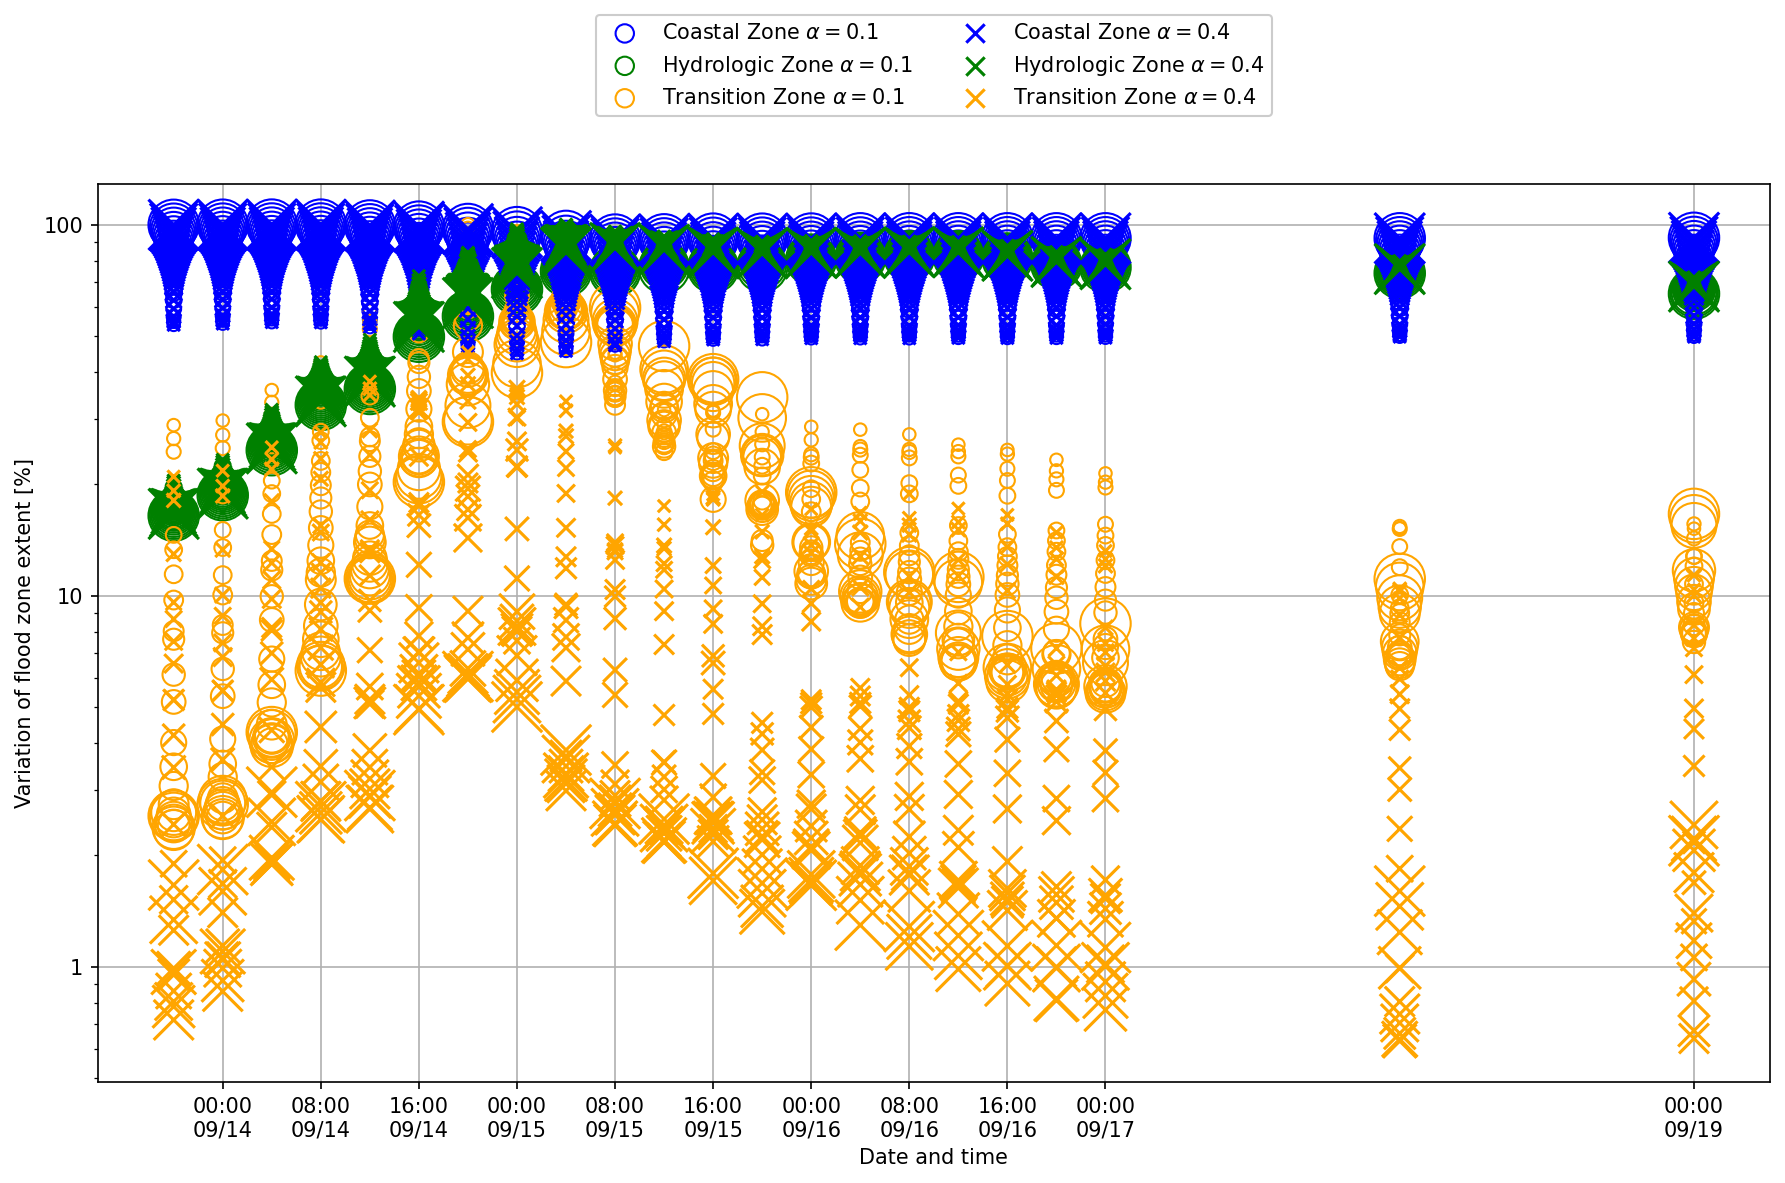

In [9]:
df = df.copy()[df["surge_h"] >= 1.1]

df["n_coastal_norm"] = 100 * df["n_coastal"] / df["n_coastal"].max()
df["n_hydro_norm"] = 100 * df["n_hydro"] / df["n_hydro"].max()
df["n_trans_norm"] = 100 * df["n_trans"] / df["n_trans"].max()

df1 = df[df.alpha_val == 0.1]
df4 = df[df.alpha_val == 0.4]

fig, ax = plt.subplots(figsize=(12, 8))

s_list1 = list(10 * 3.2**df1.surge_h)

ax.scatter(
    df1.datetime,
    df1.n_coastal_norm,
    s=s_list1,
    marker="o",
    facecolors="none",
    edgecolors="blue",
    label=r"Coastal Zone $\alpha = 0.1$",
)

ax.scatter(
    df1.datetime,
    df1.n_hydro_norm,
    s=s_list1,
    marker="o",
    facecolors="none",
    edgecolors="green",
    label=r"Hydrologic Zone $\alpha = 0.1$",
)

ax.scatter(
    df1.datetime,
    df1.n_trans_norm,
    s=s_list1,
    marker="o",
    facecolors="none",
    edgecolors="orange",
    label=r"Transition Zone $\alpha = 0.1$",
)

s_list2 = list(10 * 3.2**df4.surge_h)

ax.scatter(
    df4.datetime,
    df4.n_coastal_norm,
    s=s_list2,
    marker="x",
    c="blue",
    label=r"Coastal Zone $\alpha = 0.4$",
)

ax.scatter(
    df4.datetime,
    df4.n_hydro_norm,
    s=s_list2,
    marker="x",
    c="green",
    label=r"Hydrologic Zone $\alpha = 0.4$",
)

ax.scatter(
    df4.datetime,
    df4.n_trans_norm,
    s=s_list2,
    marker="x",
    c="orange",
    label=r"Transition Zone $\alpha = 0.4$",
)

ax.set(ylabel="Variation of flood zone extent [%]", xlabel="Date and time")

ax.grid()
ax.set_axisbelow(True)

# ax.legend(
#     loc='center left',
#     bbox_to_anchor=(1, 0.5),
#     framealpha=1,
#     markerscale=0.5
# )

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    ncol=2,
    framealpha=1,
    markerscale=0.5,
)

# [1:][::2] indicates every other element starting with second element
plt.xticks(df.datetime.unique()[1:][::2])

date_form = DateFormatter("%H:%M\n%m/%d")
ax.xaxis.set_major_formatter(date_form)

# ax.set_xscale('log')
# ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
# ax.xaxis.get_major_formatter().set_scientific(False)
# ax.xaxis.get_major_formatter().set_useOffset(False)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

fig.tight_layout()

fig.savefig("data_github/t.png", facecolor="w")


In [10]:
# ds = gdal.Open('2018091320_11_01.tif')
# band = ds.GetRasterBand(1)
# compound = band.ReadAsArray()
# ds = None

# plt.imshow(
#     compound,
#     vmin=0,
#     vmax=2,
#     cmap=transition_cmap,
#     interpolation='nearest'
#     )
